In [1]:
%load_ext autoreload
%autoreload 2
import json
import csv
import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap

import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    classification_report
)


from xgboost import XGBClassifier

d:\xie\PainAssessment\PA_data_2025_03_12\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
""" for p in range(2, 8):
    control_log_path = f'control_log/00{p}.csv'
    df_control = pd.read_csv(control_log_path)
    df_control.rename(columns={'Timestamp': 'timestamp'}, inplace=True)
    df_control.to_csv(f'control_log/00{p}.csv', index=False) """

In [ ]:
""" all_signals = pd.DataFrame()
for p in range(1, 8):
    signal_log_path = f'processed_signals/00{p}.csv'
    df_signal = pd.read_csv(signal_log_path)
    df_signal['subject'] = p
    df_signal=df_signal[['timestamp','subject','eda','bvp','temperature','systolic_peak','mode','pain']]
    all_signals = pd.concat([all_signals, df_signal], ignore_index=True)

all_signals.to_csv(f'all_.csv', index=False) """

In [ ]:
""" all_self_reports = pd.DataFrame()
for p in range(1, 8):
    self_report_log_path = f'self_report/00{p}.csv'
    df_self_report = pd.read_csv(self_report_log_path)
    df_self_report['subject'] = p
    #df_self_report=df_self_report[['timestamp','subject','eda','bvp','temperature','systolic_peak','mode','pain']]
    all_self_reports = pd.concat([all_self_reports, df_self_report], ignore_index=True)

all_self_reports.to_csv(f'all_.csv', index=False) """

In [ ]:
# Corrected signals merging
""" import pandas as pd
from datetime import timedelta

# File paths (update as needed)
for p in range(1, 2):
    control_log_path = f'control_log/00{p}.csv'
    self_report_path = f'self_report/00{p}.csv'
    signal_path = f'processed_signals/00{p}.csv'# replace with your actual path

    # Load data
    df_control = pd.read_csv(control_log_path, parse_dates=['timestamp'])
    df_self = pd.read_csv(self_report_path, parse_dates=['timestamp'])
    df_signal = pd.read_csv(signal_path, parse_dates=['timestamp'])

    # 1. Identify mode start and end times
    # Control: filter 'Selected' actions
    sel = df_control[df_control['Action'] == 'Selected'].copy()
    # Compute mode number (mode = PainLevel + 1)
    sel['mode'] = sel['PainLevel'] + 1
    # Start times: first selection per mode
    mode_intervals = sel.groupby('mode')['timestamp'].agg(start='min', last_sel='max').reset_index()
    print(mode_intervals)
    # Self-report finish attempts
    finish = df_self[df_self['Action'] == 'Finish Button Attempted'][['timestamp']]

    # Determine end times
    ends = []
    for _, row in mode_intervals.iterrows():
        mode = row['mode']
        last_sel = row['last_sel']
        # window of 5 seconds after last selection
        window = finish[
            (finish['timestamp'] >= last_sel) & 
            (finish['timestamp'] <= last_sel + timedelta(seconds=5))
        ]
        if not window.empty:
            end_time = window['timestamp'].iloc[0]  # first finish attempt
        else:
            end_time = last_sel + timedelta(seconds=3)
        ends.append(end_time)

    mode_intervals['end'] = ends

    # 2. Label signal DataFrame
    df_signal = df_signal.sort_values('timestamp')
    df_signal['mode'] = 0
    for _, row in mode_intervals.iterrows():
        mask = (df_signal['timestamp'] >= row['start']) & (df_signal['timestamp'] <= row['end'])
        df_signal.loc[mask, 'mode'] = row['mode']

    # 3. Align and copy self-reported pain to signal DataFrame
    # Assuming df_self has columns ['timestamp', 'PainLevel'] for self-reports.
    # Merge_asof to find nearest self-report for each signal timestamp
    df_self_sorted = df_self.sort_values('timestamp')[['timestamp', 'PainLevel']]

    #df_signal = pd.merge_asof(df_signal, df_self_sorted, on='timestamp', direction='nearest')
    # Assign each self-report to the nearest signal timestamp
    for _, rep in df_self.iterrows():
        diffs = (df_signal['timestamp'] - rep['timestamp']).abs()
        nearest_idx = diffs.idxmin()
        df_signal.at[nearest_idx, 'pain'] = rep['PainLevel']
    df_signal.drop('Mode', axis=1, inplace=True,)
    #df_signal.rename(columns={'PainLevel': 'pain'}, inplace=True)

    # 4. Save or inspect
    df_signal.to_csv(f'processed_signals/00{p}_.csv', index=False)
    #df_signal.head(10) """


In [3]:
from src.dataset_c import BiomedicalPainDataset
from src.model.transformer import TransformerClassifier

In [40]:
# testing
def window_filter(df):
    # filter windows from one single subject and one mode
    return df['mode'].nunique() == 1# and df['subject'].nunique() == 1

# Load data
subject=p=4
signals_df = pd.read_csv(f'processed_signals/001.csv')
#signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
pain_df = pd.read_csv(f'self_report/001.csv')
# Hyper-parameters

window_size=1.0
step_size=1.0
tonic_cutoff_freq = 0.05  # 20 Hz

# 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
test_ds = BiomedicalPainDataset(
    signals_df=signals_df,
    pain_df=pain_df,
    timestamp_col='timestamp',
    window_size=window_size,
    step_size=step_size,
    signal_columns=['eda','bvp','temperature'],
    window_filter=window_filter,  # filter windows by subject and mode
    bandpass_freqs=(0.5,40),
    freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,60)],
    resample_freq=100,
    include_tonic_phasic=True,
    tonic_cutoff=tonic_cutoff_freq,
    use_raw_signals=True
)

def dataset_to_numpy(dataset: torch.utils.data.Dataset):
        loader = DataLoader(dataset, batch_size=64, shuffle=False,drop_last=True)
        X_parts, Y_parts = [], []
        for Xb, Yb in loader:
            X_parts.append(Xb)
            Y_parts.append(Yb)
        X = torch.cat(X_parts, dim=0).numpy()
        Y = torch.cat(Y_parts, dim=0).flatten().numpy()
        return X, Y

X_test, y_test  = dataset_to_numpy(test_ds) # type: ignore

In [46]:
X_test.shape, y_test.shape

((1792, 100, 3), (1792,))

In [ ]:
# testing
def split_func(df:pd.DataFrame, window_indices: list[tuple[int, int]]):
    """
    Custom split function to determine train/test splits.
    Returns indices for train and test sets.
    """
    # Use 'mode' column to split
    ends = [tgt for (_, tgt) in window_indices]
    df_end = df.iloc[ends]
    train_modes = [0,1,3,5]

    # Use 'subject' column to split
    ends = [tgt for (_, tgt) in window_indices]
    df_end = df.iloc[ends]
    train_subjects = [i for i in range(1, 8) if i not in [1]]  # Exclude subjects 1
    # Split into train and test indices
    train_condition = df_end['subject'].isin(train_subjects)
    train_idxs = np.where(train_condition)[0]
    test_idxs  = np.where(~train_condition)[0]

    print("Train indices:", train_idxs[-1])
    print("Test indices:", test_idxs[-1])
    return train_idxs, test_idxs

train_ds_test, test_ds_test = test_ds.split( # type: ignore
    split_func=split_func,)

In [ ]:
""""
To-do:
-X identify the start of each mode from the self-report data and the end of each mode from the control log data
-X find the nearest timestamps (row) of these starts and ends in the signals data
-X label the mode of each row in the signals data based on these starts and ends (0 for no mode, 1 for mode 1, 2 for mode 2, etc.)
- change the biomedical pain dataset class methods to use these labels accordingly
- implement a function to compute the pain level based on the last report before the target index
"""

In [ ]:
# with SHAP and loop through all combinations of hyper-parameters

# Build master results DataFrame
results = pd.DataFrame()
# window filter
def window_filter(df):
    # filter windows from one single subject and one mode
    return df['mode'].nunique() == 1 and df['subject'].nunique() == 1

SUBJECTS = [i for i in range(5, 8)]  # negative values mean all subjects except for that subject, e.g., -1 is all subjects except 1
TONIC_CUTOFFS = [0.1] # [0.05, 0.1, 0.25] 
WINDOW_DURATIONS = [0.5, 1.0, 5.0]  # seconds
WINDOW_STEPS = [0.5, 1.0, 5.0]  # seconds
SPLIT_METHODS = ['split',]
signals_df = pd.read_csv(f'processed_signals/all.csv')
pain_df = pd.read_csv(f'self_report/all.csv')
"""
Experiment design:
record both training and testing metrics

1. Train on 6 subjects; Test on one separate subject
- Train on some modes of the training subjects, test on the same modes/and the other modes of the test subjects
- Train on all modes of the training subjects, test on all modes of the test subjects
2. Train and test on the same subject
- Train on some modes, test on others
- Train on all modes, test on all modes (stratify)
3. Train on all subjects, test on all subjects
- Train on some modes, test on others
- Train on all modes, test on all modes (stratify)
"""


# loop through all combinations of hyper-parameters
for p, tonic_cutoff, window_size, step_size, split_method in itertools.product(
        SUBJECTS,
        TONIC_CUTOFFS,
        WINDOW_DURATIONS,
        WINDOW_STEPS,
        SPLIT_METHODS,
):
    params = {
        'test_subject': p,
        'tonic_cutoff': tonic_cutoff,
        'window_size': window_size,
        'step_size': step_size,
        'split_method': split_method
    }
    print(f"\nRunning for params: {params}")
    # Load data
    subject=p
    #signals_df = pd.read_csv(f'processed_signals/00{p}.csv')
    #signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
    #pain_df = pd.read_csv(f'self_report/00{p}.csv')


    # 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
    ds = BiomedicalPainDataset(
        signals_df=signals_df,
        pain_df=pain_df,
        timestamp_col='timestamp',
        window_size=window_size,
        step_size=step_size,
        signal_columns=['eda','bvp','temperature'],
        window_filter=window_filter,  # filter windows by subject and mode
        bandpass_freqs=(0.5, 45),  # 45 < 50 (Nyquist for 100Hz)
        freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,45)],  # also update freq_bands to not exceed 45Hz
        resample_freq=100,
        include_tonic_phasic=True,
        tonic_cutoff=tonic_cutoff,
        use_raw_signals=False
    )
    def split_func(df:pd.DataFrame, window_indices: list[tuple[int, int]]):
        """
        Custom split function to determine train/test splits.
        Returns indices for train and test sets.
        """
        # Use 'subject' column to split
        ends = [tgt for (_, tgt) in window_indices]
        df_end = df.iloc[ends]
        train_subjects = [i for i in range(1, 8) if i not in [p]]  # Exclude subjects p
        # Split into train and test indices
        train_condition = df_end['subject'].isin(train_subjects)
        train_idxs = np.where(train_condition)[0]
        test_idxs  = np.where(~train_condition)[0]

        return train_idxs, test_idxs
    
    if split_method == 'split':
        #train_ds, test_ds = ds.split(test_size=0.2, split_by=['mode']) # type: ignore
        train_ds, test_ds = ds.split(split_func=split_func) # type: ignore
    elif split_method == 'stratify':
        train_ds, test_ds = ds.split(test_size=0.2, stratify_by=['mode']) # type: ignore
    train_ds.apply_scaling('standard', fit=True)

    # store the train_ds scaler for later use
    train_scaler = train_ds.scaler
    test_ds.apply_scaling('standard', fit=False, scaler=train_scaler)  # uses train_ds.scaler

    train_ds.process_nan('interpolate', 'linear')

    # 2) Helper to convert any BaseSlidingWindowDataset into X, Y NumPy arrays
    def dataset_to_numpy(dataset: torch.utils.data.Dataset):
        loader = DataLoader(dataset, batch_size=64, shuffle=False,drop_last=True)
        X_parts, Y_parts = [], []
        for Xb, Yb in loader:
            X_parts.append(Xb)
            Y_parts.append(Yb)
        X = torch.cat(X_parts, dim=0).numpy()
        Y = torch.cat(Y_parts, dim=0).flatten().numpy()
        return X, Y

    X_train, y_train = dataset_to_numpy(train_ds) # type: ignore
    X_test,  y_test  = dataset_to_numpy(test_ds) # type: ignore

    # 3) (Optional) Balance your training set with a WeightedRandomSampler
    class_counts = np.bincount(y_train.astype(int))
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train.astype(int)]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True) # type: ignore

    # Wrap balanced train set into a single batch
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
        sampler=sampler,
        batch_size=len(y_train)
    )
    X_train_bal, y_train_bal = next(iter(train_loader))
    X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

    # 4) Define your modeling pipelines
    def make_pipeline(estimator):
        return Pipeline([
            #('impute', SimpleImputer(strategy='mean')),
            #('scale',  StandardScaler()),
            ('clf',    estimator)
        ])
    
    models = {
        #'SVM':               make_pipeline(SVC(kernel='rbf', probability=True, random_state=42)),
        'RandomForest':      make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42)),
        #'GradientBoosting':  make_pipeline(GradientBoostingClassifier(random_state=42)),
        #'KNeighbors':        make_pipeline(KNeighborsClassifier(n_neighbors=5)),
        #'LogisticRegression':make_pipeline(LogisticRegression(max_iter=1000, random_state=42)),
        'XGBoost':           make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
        #'MLP':         make_pipeline(MLPClassifier(hidden_layer_sizes=(256,256,256,256), learning_rate='adaptive', max_iter=500, random_state=42)),
            # requires tensorflow
        #'NaiveBayes':        make_pipeline(GaussianNB()),
        #'Transformer':     make_pipeline(TransformerClassifier(3, seq_len=X_train_bal.shape[1],d_model=128,num_classes=3)),  # type: ignore
    }

    # --- 0) Optionally subsample for SHAP speed ---
    # we'll take 1000 train and 500 test samples at random
    rng = np.random.RandomState(42)
    idx_train = rng.choice(len(X_train_bal), size=min(200, len(X_train_bal)), replace=False)
    idx_test  = rng.choice(len(X_test),      size=min(100,  len(X_test)),      replace=False)
    X_train_sub, y_train_sub = X_train_bal[idx_train], y_train_bal[idx_train]
    X_test_sub,  y_test_sub  = X_test[idx_test],    y_test[idx_test]

    #feature_names = [f"f{i}" for i in range(X_train.shape[1])]  # replace with real names if available
    feature_names = ds._generate_feature_names()  # use dataset's feature names

    # 5) Train & evaluate
    for name, pipe in models.items():
        pipe.fit(X_train_bal, y_train_bal)
        y_pred = pipe.predict(X_test)
        print(f"\n=== {name} ===")
        f1 = f1_score( y_test, y_pred, average='macro' )
        f1_train = f1_score( y_train_bal, pipe.predict(X_train_bal), average='macro')
        print("F1 (macro) train:", f1_train)
        bal_acc_train = balanced_accuracy_score(y_train_bal, pipe.predict(X_train_bal))
        print("Balanced Accuracy train:", bal_acc_train)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        print("F1 (macro):",            f1)
        print("Balanced Accuracy:",     bal_acc)
        #print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
        """ 
        # Choose appropriate explainer
        clf = pipe.named_steps['clf']
        transformer = Pipeline(pipe.steps[:-1])  # imputer+scaler
        X_train_trans = transformer.transform(X_train_sub)
        X_test_trans  = transformer.transform(X_test_sub)
        
        if name in ('RandomForest','GradientBoosting','XGBoost'):
            explainer = shap.TreeExplainer(clf, data=X_train_trans)
            # Compute SHAP values for class 1 (or mean over classes)
            shap_values = explainer.shap_values(X_test_trans, check_additivity=False)
        elif name in ('MLP'):
            explainer = shap.DeepExplainer(clf, X_train_trans[:100])  # MLP needs a small background set
            shap_values = explainer.shap_values(X_test_trans)
        else:
            # Kernel explainer on small background
            explainer = shap.KernelExplainer(clf.predict_proba, X_train_trans[:100])
            shap_values = explainer.shap_values(X_test_trans)
        # shap_values is list of arrays if multiclass
        if isinstance(shap_values, list):
            # take class 1 explanations
            sv = shap_values[1]
        else:
            sv = shap_values
            
        # Mean absolute importance per feature
        # If sv is 2D, mean over samples only
        if sv.ndim == 2:
            mean_abs = np.abs(sv).mean(axis=0)
        elif sv.ndim == 3:
            mean_abs = np.abs(sv).mean(axis=(0, 2))
        ranked_ix = np.argsort(-mean_abs) # type: ignore
        print("Top features by mean(|SHAP|):")
        top_k = 3
        for i in ranked_ix[:top_k]:
            print(f"  {feature_names[int(i)]:<25} : {mean_abs[int(i)]:.4f}") # type: ignore

        top_k = 15
        top_idx   = ranked_ix[:]                      # indices of top K
        top_feats = [feature_names[i] for i in top_idx]    # their names
        top_vals  = [mean_abs[i] for i in top_idx]         # their SHAP importances """
        
        # Record a row
        row = {**params,
            'model': name,
            'f1_macro': f1,
            'balanced_acc': bal_acc,
            #'top_shap_feats':  top_feats,
            #'top_shap_vals':   top_vals,
            }
        results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

        # Persist after each run
        results.to_csv('experiments_raw.csv', index=False)
        results.to_feather('experiments_raw.feather')

        print(f"Finished {name} {params} → F1={f1:.3f}, BalAcc={bal_acc:.3f}")


In [ ]:
# DEEP with SHAP and loop through all combinations of hyper-parameters

# Build master results DataFrame
results = pd.DataFrame()

SUBJECTS = [i for i in range(4, 0, -1)]  # negative values mean all subjects except for that subject, e.g., -1 is all subjects except 1
TONIC_CUTOFFS = [0.1] # [0.05, 0.1, 0.25] 
WINDOW_DURATIONS = [3.0, 5.0]  # seconds
WINDOW_STEPS = [0.05,]  # seconds
SPLIT_METHODS = ['split',]
signals_df = pd.read_csv(f'processed_signals/all.csv')
pain_df = pd.read_csv(f'self_report/all.csv')
"""
Experiment design:
record both training and testing metrics

1. Train on 6 subjects; Test on one separate subject
- Train on some modes of the training subjects, test on the same modes/and the other modes of the test subjects
- Train on all modes of the training subjects, test on all modes of the test subjects
2. Train and test on the same subject
- Train on some modes, test on others
- Train on all modes, test on all modes (stratify)
3. Train on all subjects, test on all subjects
- Train on some modes, test on others
- Train on all modes, test on all modes (stratify)
"""


# loop through all combinations of hyper-parameters
for p, tonic_cutoff, window_size, step_size, split_method in itertools.product(
        SUBJECTS,
        TONIC_CUTOFFS,
        WINDOW_DURATIONS,
        WINDOW_STEPS,
        SPLIT_METHODS,
):
    params = {
        'test_subject': p,
        'tonic_cutoff': tonic_cutoff,
        'window_size': window_size,
        'step_size': step_size,
        'split_method': split_method
    }
    print(f"\nRunning for params: {params}")
    # Load data
    subject=p
    #signals_df = pd.read_csv(f'processed_signals/00{p}.csv')
    #signals_df.drop(columns=['accelerometer_x',	'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y',	'gyroscope_z'], inplace=True)
    #pain_df = pd.read_csv(f'self_report/00{p}.csv')

    # window filter
    def window_filter(df):
        # filter windows from one single subject and one mode
        return df['mode'].nunique() == 1 and df['subject'].nunique() == 1 and df['subject'].iloc[0] == p
    # 1) Instantiate and split your sliding-window pain dataset by 'Mode' groups
    ds = BiomedicalPainDataset(
        signals_df=signals_df, 
        pain_df=pain_df,
        timestamp_col='timestamp',
        window_size=window_size,
        step_size=step_size,
        signal_columns=['eda','bvp','temperature'],
        window_filter=window_filter,  # filter windows by subject and mode
        bandpass_freqs=(0.5, 45),  # 45 < 50 (Nyquist for 100Hz)
        freq_bands=[(0.5,4),(4,8),(8,12),(12,30),(30,45)],  # also update freq_bands to not exceed 45Hz
        resample_freq=100,
        include_tonic_phasic=True,
        tonic_cutoff=tonic_cutoff,
        use_raw_signals=True
    )
    def split_func(df:pd.DataFrame, window_indices: list[tuple[int, int]]):
        """
        Custom split function to determine train/test splits.
        Returns indices for train and test sets.
        """
        # Use 'subject' column to split
        ends = [tgt for (_, tgt) in window_indices]
        df_end = df.iloc[ends]
        train_subjects = [i for i in range(1, 8) if i not in [p]]  # Exclude subjects p
        # Split into train and test indices
        train_condition = df_end['subject'].isin(train_subjects)
        train_idxs = np.where(train_condition)[0]
        test_idxs  = np.where(~train_condition)[0]

        return train_idxs, test_idxs
    if split_method == 'split':
        train_ds, test_ds = ds.split(test_size=0.2, split_by=['mode']) # type: ignore
        #train_ds, test_ds = ds.split(split_func=split_func) # type: ignore
    elif split_method == 'stratify':
        train_ds, test_ds = ds.split(test_size=0.2, stratify_by=['mode']) # type: ignore
    train_ds.apply_scaling('standard', fit=True)

    # store the train_ds scaler for later use
    train_scaler = train_ds.scaler
    test_ds.apply_scaling('standard', fit=False, scaler=train_scaler)  # uses train_ds.scaler

    train_ds.process_nan('interpolate', 'linear')

    # 2) Helper to convert any BaseSlidingWindowDataset into X, Y NumPy arrays
    def dataset_to_numpy(dataset: torch.utils.data.Dataset):
        loader = DataLoader(dataset, batch_size=64, shuffle=False,drop_last=False)
        X_parts, Y_parts = [], []
        for Xb, Yb in loader:
            X_parts.append(Xb)
            Y_parts.append(Yb)
        X = torch.cat(X_parts, dim=0).numpy()
        Y = torch.cat(Y_parts, dim=0).flatten().numpy()
        return X, Y

    X_train, y_train = dataset_to_numpy(train_ds) # type: ignore
    X_test,  y_test  = dataset_to_numpy(test_ds) # type: ignore

    # 3) (Optional) Balance your training set with a WeightedRandomSampler
    class_counts = np.bincount(y_train.astype(int))
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train.astype(int)]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True) # type: ignore

    # Wrap balanced train set into a single batch
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
        sampler=sampler,
        batch_size=len(y_train)
    )
    X_train_bal, y_train_bal = next(iter(train_loader))
    X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

    # 4) Define your modeling pipelines
    def make_pipeline(estimator):
        return Pipeline([
            #('impute', SimpleImputer(strategy='mean')),
            #('scale',  StandardScaler()),
            ('clf',    estimator)
        ])
    
    # Ensure targets are in the correct range and num_classes matches
    n_classes = len(np.unique(y_train_bal))
    print("Unique classes in y_train_bal:", np.unique(y_train_bal))
    assert np.all(np.isin(y_train_bal, np.arange(n_classes))), "Targets out of bounds for num_classes"

    models = {
        'Transformer':     make_pipeline(TransformerClassifier(input_dim=X_train_bal.shape[2],
                                            seq_len=X_train_bal.shape[1],d_model=32,num_classes=n_classes,
                                            n_heads=4,num_layers=1,lr=1e-4,batch_size=128)),  # type: ignore
    }

    """ # --- 0) Optionally subsample for SHAP speed ---
    # we'll take 1000 train and 500 test samples at random
    rng = np.random.RandomState(42)
    idx_train = rng.choice(len(X_train_bal), size=min(200, len(X_train_bal)), replace=False)
    idx_test  = rng.choice(len(X_test),      size=min(100,  len(X_test)),      replace=False)
    X_train_sub, y_train_sub = X_train_bal[idx_train], y_train_bal[idx_train]
    X_test_sub,  y_test_sub  = X_test[idx_test],    y_test[idx_test]

    #feature_names = [f"f{i}" for i in range(X_train.shape[1])]  # replace with real names if available
    feature_names = ds._generate_feature_names()  # use dataset's feature names """

    # 5) Train & evaluate
    for name, pipe in models.items():
        pipe.fit(X_train_bal, y_train_bal)
        y_pred = pipe.predict(X_test)
        print(f"\n=== {name} ===")
        f1_train = f1_score( y_train_bal, pipe.predict(X_train_bal), average='macro' )
        print("F1 (train, macro):", f1_train)
        bal_acc_train = balanced_accuracy_score(y_train_bal, pipe.predict(X_train_bal))
        print("Balanced Accuracy (train):", bal_acc_train)
        f1 = f1_score(y_test, y_pred, average='macro' )
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        print("F1 (macro):",            f1)
        print("Balanced Accuracy:",     bal_acc)
        #print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
        
        # Record a row
        row = {**params,
            'model': name,
            'f1_macro': f1,
            'balanced_acc': bal_acc,
            'top_shap_feats':  None,
            'top_shap_vals':   None,
            }
        results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

        # Persist after each run
        results.to_csv('experiments_raw.csv', index=False)
        results.to_feather('experiments_raw.feather')

        print(f"Finished {name} {params} → F1={f1:.3f}, BalAcc={bal_acc:.3f}")

In [32]:
y_train_bal.shape

(1024,)

In [20]:
len(y_train_bal), len(y_test), len(X_train), len(X_test)

(4288, 384, 4288, 384)

In [18]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True) # type: ignore

# Wrap balanced train set into a single batch
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
    sampler=sampler,
    batch_size=len(y_train)
)
X_train_bal, y_train_bal = next(iter(train_loader))
X_train_bal = X_train_bal.numpy();  y_train_bal = y_train_bal.numpy()

np.where(y_train_bal == 0)[0].shape, np.where(y_train_bal == 1)[0].shape, np.where(y_train_bal == 2)[0].shape

((1437,), (1493,), (1358,))

In [ ]:
np.where(y_train_bal == 0)[0].shape, np.where(y_train_bal == 1)[0].shape, np.where(y_train_bal == 2)[0].shape

((3665,), (338,), (285,))

In [ ]:
import torch.nn as nn
closs = nn.CrossEntropyLoss()
# CrossEntropyLoss expects input as (N, C) logits and target as class indices (Long)
# Example: 3 samples, 3 classes
logits = torch.tensor([[2.0, 1.0, 0.1], [0.5, 2.5, 0.3], [0.1, 0.2, 3.0]])  # shape (3, 3)
targets = torch.tensor([0, 1, 2])  # shape (3,)
closs(logits, targets)

(torch.Size([3]), torch.Size([3, 3]), 0.24889366328716278)

In [23]:
results.sort_values(by='f1_macro', ascending=False)

,test_subject,tonic_cutoff,window_size,step_size,split_method,model,f1_macro,balanced_acc,top_shap_feats,top_shap_vals
3,1,0.1,0.5,1.0,split,XGBoost,0.407401,0.424739,"[temperature_tonic_var, eda_kurt, bvp_min, tem...","[0.2700007147268465, 0.2503363355592893, 0.242..."
7,1,0.1,1.0,0.5,split,XGBoost,0.400605,0.428840,"[temperature_tonic_var, bvp_mean, eda_30-45Hz,...","[0.40844412859652884, 0.2373989280549461, 0.22..."
1,1,0.1,0.5,0.5,split,XGBoost,0.395366,0.422466,"[temperature_tonic_var, bvp_mean, temperature_...","[0.36309761964230275, 0.2910155458142778, 0.21..."
9,1,0.1,1.0,1.0,split,XGBoost,0.390799,0.422146,"[eda_kurt, temperature_tonic_var, bvp_mean, te...","[0.25277478730146363, 0.23937776778794198, 0.2..."
15,1,0.1,5.0,1.0,split,XGBoost,0.385424,0.407065,"[eda_tonic_mean, eda_30-45Hz, temperature_max,...","[0.4268423863183097, 0.3418539276757067, 0.311..."
...,...,...,...,...,...,...,...,...,...,...
85,5,0.1,5.0,0.5,split,XGBoost,0.256318,0.329772,"[eda_tonic_mean, eda_30-45Hz, bvp_rms, eda_4-8...","[0.24645349569617772, 0.23941753706002236, 0.2..."
84,5,0.1,5.0,0.5,split,RandomForest,0.254126,0.333179,"[eda_0.5-4Hz, eda_tonic_mean, temperature_max,...","[0.0169636380103712, 0.015093689931290349, 0.0..."
80,5,0.1,1.0,1.0,split,RandomForest,0.254107,0.333333,"[temperature_tonic_var, bvp_rms, bvp_range, bv...","[0.013098430932489004, 0.012528633192568178, 0..."
78,5,0.1,1.0,0.5,split,RandomForest,0.253656,0.333060,"[bvp_min, bvp_skew, temperature_tonic_var, eda...","[0.015475118314425839, 0.01434020839549062, 0...."


In [ ]:
loader = DataLoader(train_ds, batch_size=32, shuffle=False,drop_last=True)
X_parts, Y_parts = [], []
for Xb, Yb in loader:
    X_parts.append(Xb)
    Y_parts.append(Yb)
X = torch.cat(X_parts, dim=0).numpy()
Y = torch.cat(Y_parts, dim=0).flatten().numpy()

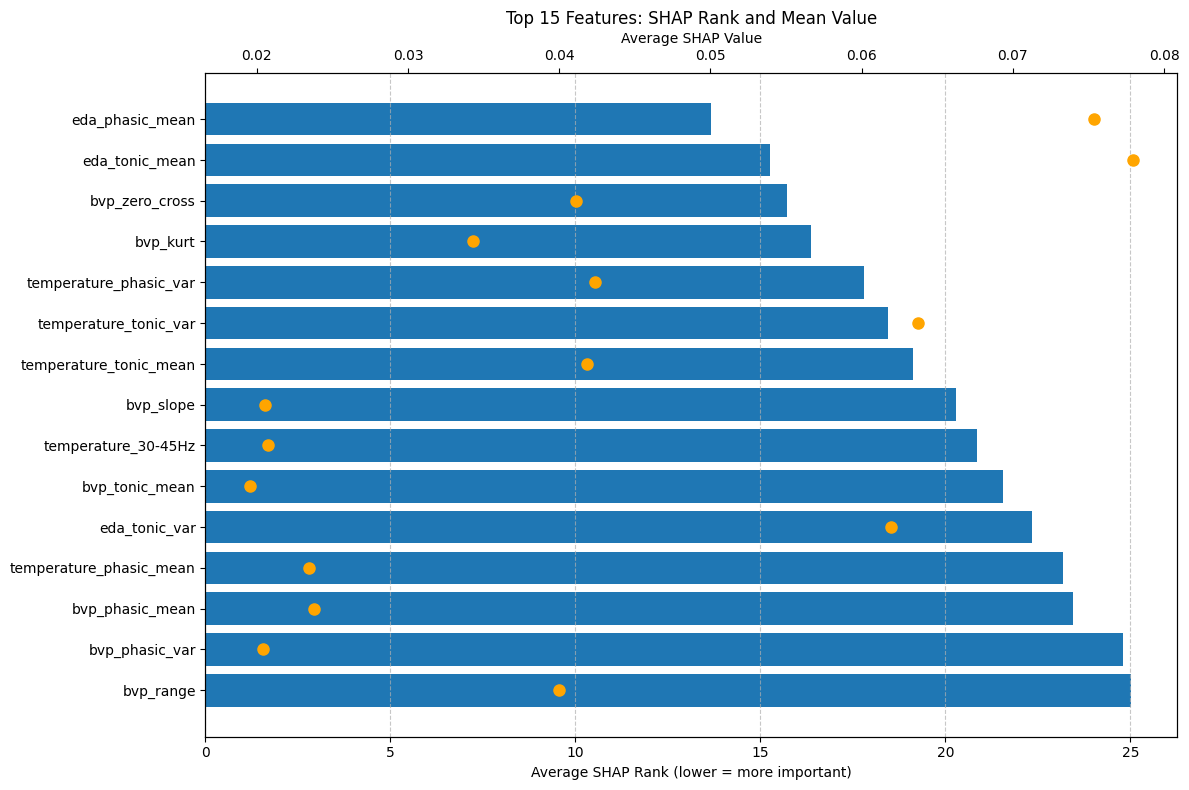

In [51]:
# Collect all features seen
all_feats = sorted({feat for feats in results['top_shap_feats'] for feat in feats})

# Build average rank DataFrame
def make_rank_map(feats):
    return {feat: feats.index(feat) + 1 if feat in feats else np.nan for feat in all_feats}

pos_df = pd.DataFrame(results['top_shap_feats'].apply(make_rank_map).tolist())
# Penalize absent features
K = results['top_shap_feats'].str.len().max()
pos_df = pos_df.fillna(K + 1)
avg_rank = pos_df.mean()

# Build average value DataFrame
def make_val_map(feats, vals):
    return {feat: vals[feats.index(feat)] if feat in feats else 0.0 for feat in all_feats}

val_df = pd.DataFrame([
    make_val_map(feats, vals)
    for feats, vals in zip(results['top_shap_feats'], results['top_shap_vals'])
])
avg_val = val_df.mean()

# Select top 15 by avg_rank
top15 = avg_rank.nsmallest(15).index

# Prepare data for plotting
ranks = avg_rank[top15]
values = avg_val[top15]

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(top15))

# Bar for average rank
ax1.barh(y_pos, ranks, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top15)
ax1.invert_yaxis()
ax1.set_xlabel('Average SHAP Rank (lower = more important)')
ax1.set_title('Top 15 Features: SHAP Rank and Mean Value')

# Secondary axis for SHAP value
ax2 = ax1.twiny()
ax2.plot(values, y_pos, 'o', color='orange', markersize=8, label='Average SHAP Value')
ax2.set_xlabel('Average SHAP Value')

# Grid and layout
ax1.grid(axis='x', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

In [46]:
for feat in results['top_shap_feats'][0]:
    avg_rank = results['top_shap_feats'].apply(list.index, args=(feat,)).mean()
    print(f"Feature: {feat}, Average Rank: {avg_rank}")


Feature: temperature_tonic_var, Average Rank: 17.457875457875456
Feature: bvp_tonic_var, Average Rank: 26.043956043956044
Feature: temperature_tonic_mean, Average Rank: 18.135531135531135
Feature: bvp_phasic_mean, Average Rank: 22.44322344322344
Feature: eda_phasic_var, Average Rank: 27.38095238095238
Feature: eda_phasic_mean, Average Rank: 12.677655677655677
Feature: eda_tonic_var, Average Rank: 21.35164835164835
Feature: bvp_phasic_var, Average Rank: 23.7985347985348
Feature: eda_max, Average Rank: 35.24908424908425
Feature: bvp_tonic_mean, Average Rank: 20.553113553113555
Feature: eda_kurt, Average Rank: 35.02930402930403
Feature: eda_tonic_mean, Average Rank: 14.267399267399268
Feature: bvp_skew, Average Rank: 25.516483516483518
Feature: eda_range, Average Rank: 35.959706959706956
Feature: temperature_rms, Average Rank: 32.73992673992674
Feature: temperature_phasic_mean, Average Rank: 22.17948717948718
Feature: bvp_rms, Average Rank: 28.457875457875456
Feature: eda_var, Average Ran

In [77]:
results.columns

Index(['subject', 'tonic_cutoff', 'window_duration', 'step_size',
       'split_method', 'model', 'f1_macro', 'balanced_acc', 'top_shap_feats',
       'top_shap_vals'],
      dtype='object')

<Axes: xlabel='model', ylabel='balanced_acc'>

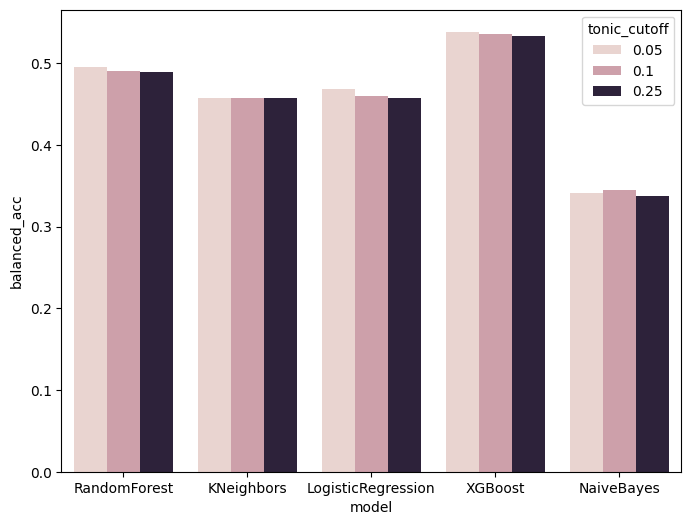

In [84]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(results, x='model', y='balanced_acc', hue='tonic_cutoff', errorbar=None, )

<Axes: xlabel='model', ylabel='balanced_acc'>

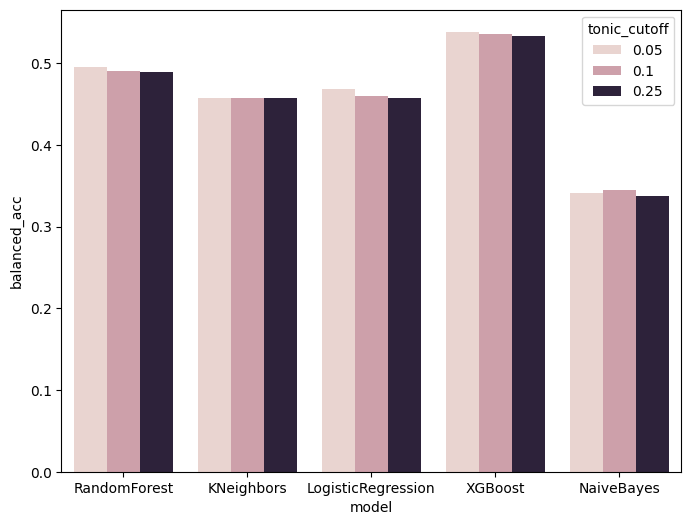

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(results, x='model', y='balanced_acc', hue='tonic_cutoff', errorbar=None, )

# Data processing

## 1. Sliding window

- window size
- window overlap

## 2. Raw data

### 1. synchronization/interpolation
- Forward fill
- Linear interpolation
- B-spline

## 3. Train-test split

- random splitting (might have information leak)
- split by pain stimulation mode
- spit by subject (leave one subject out)


# Data analysis

## 1. Statistical analysis

## 2. Machine Learning Models